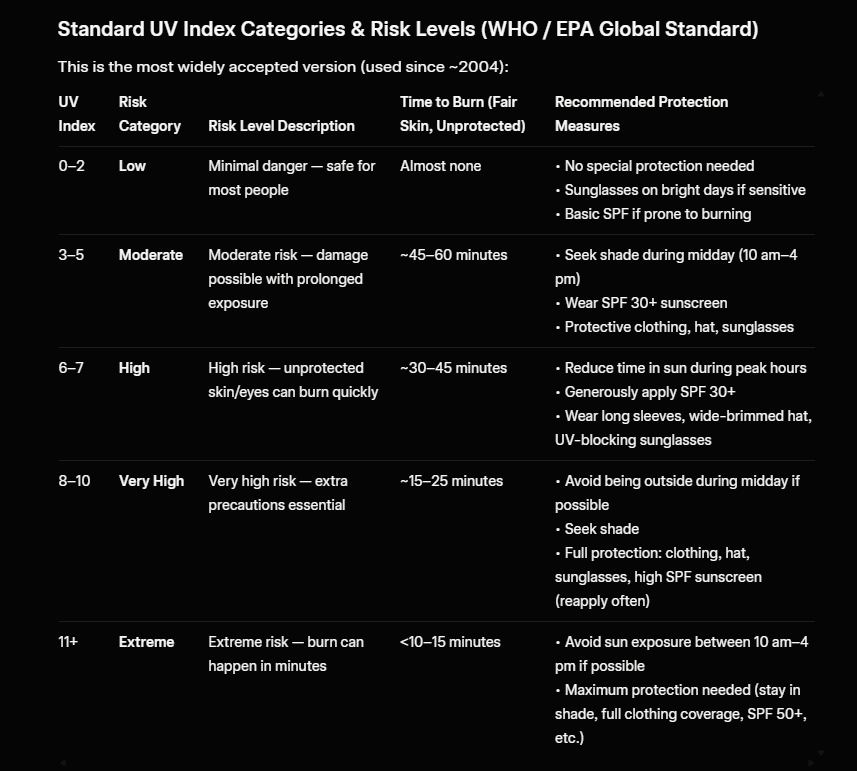
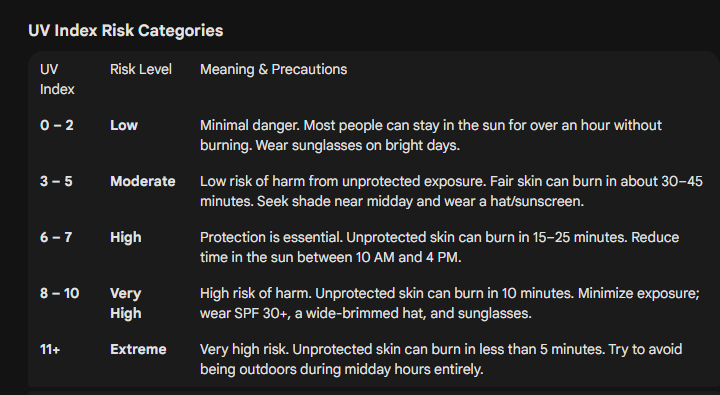

In [260]:
# might need a corillation matrix for testing as its not comming from formulae

In [ ]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

In [263]:
df_bandarban.head()

,district,day,month,year,temperature(degree C),feels_like(degree C),max_temperature(degree C),minimum_temperature(degree C),humidity,precipitation,windspeed,atmospheric_pressure,UV,solar_radiation,dew_point
0,Bandarban,1,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bandarban,2,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bandarban,3,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bandarban,4,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bandarban,5,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [264]:
df_bandarban = df_bandarban.drop('district', axis =1 )

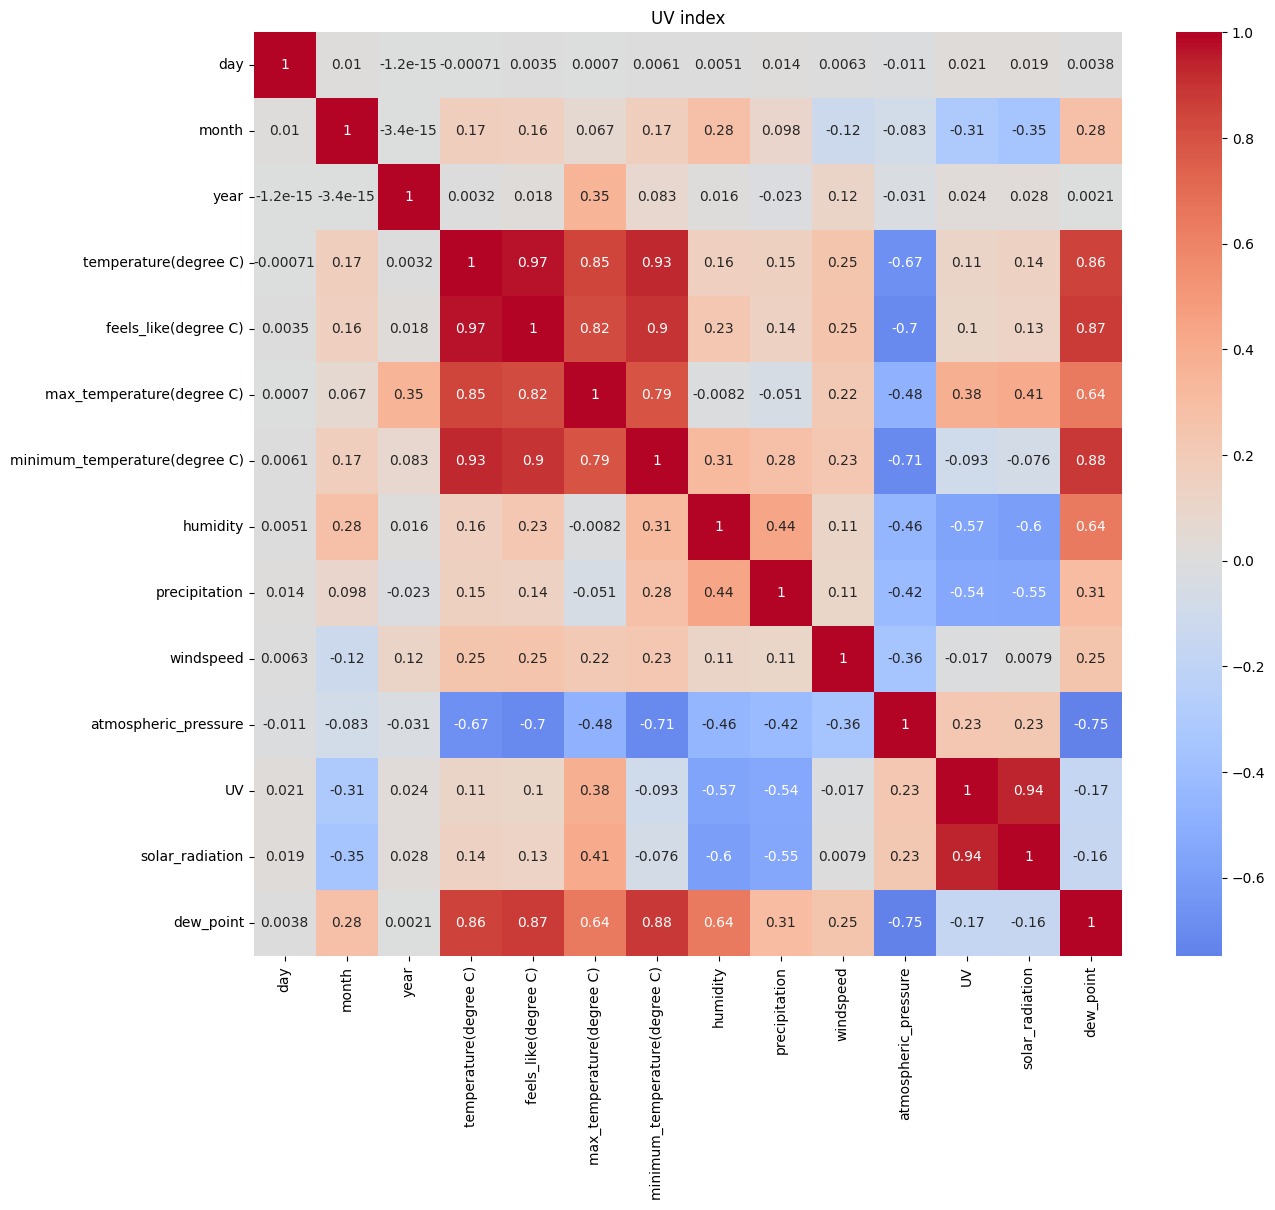

In [265]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a correlation matrix
corr_matrix = df_bandarban.corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('UV index')
plt.show()

In [266]:
# X = [
#     'solar_radiation', 
#     'humidity',
#     'max_temperature(degree C)',
#     'month_sin', 'month_cos',  # Captures yearly seasonality
#     'day_sin', 'day_cos',      # Captures monthly cycles
#     'atmospheric_pressure'
# ]

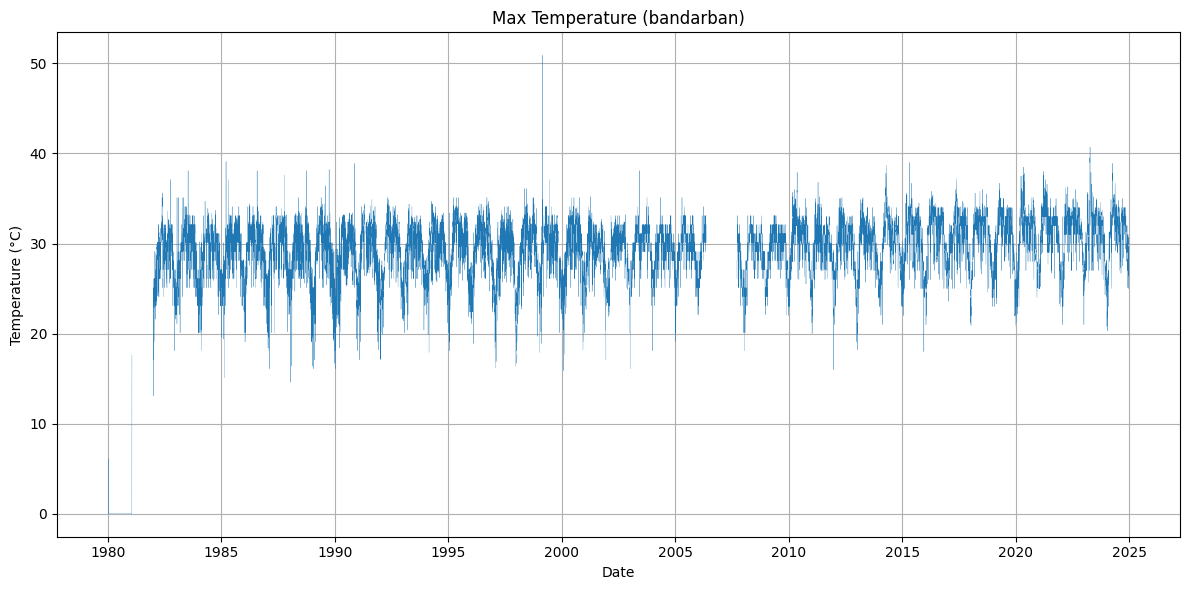

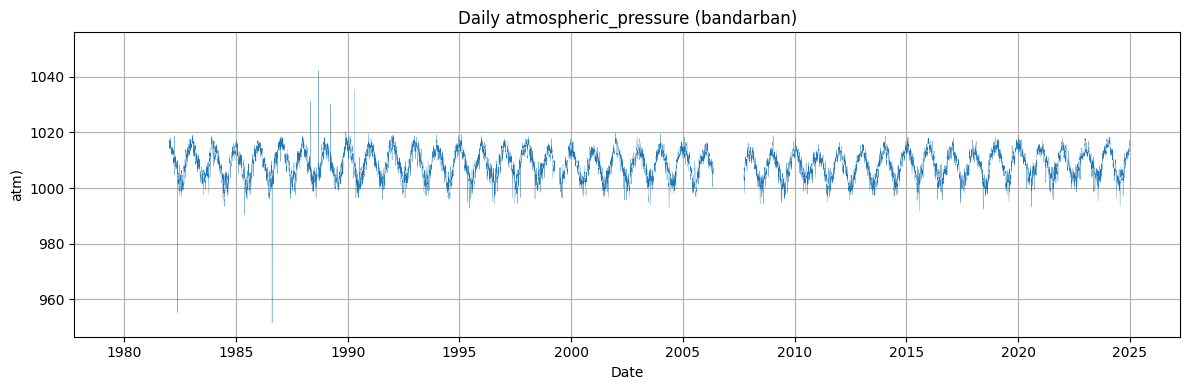

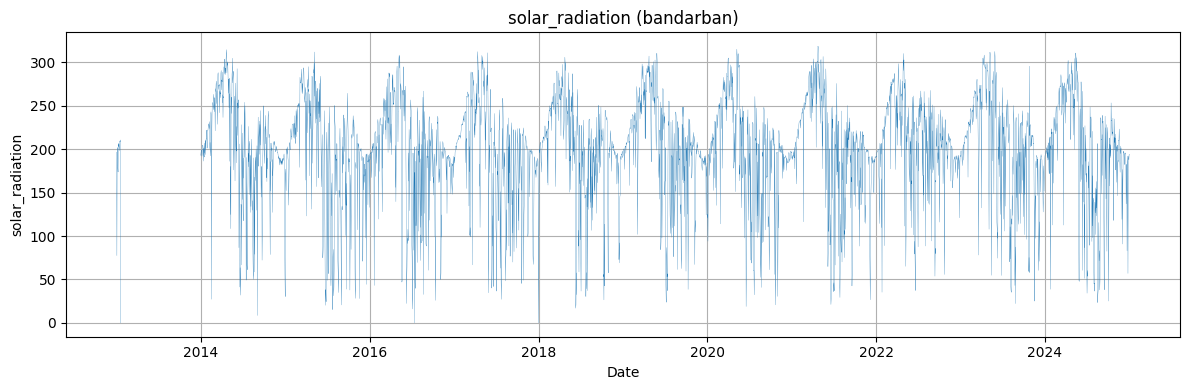

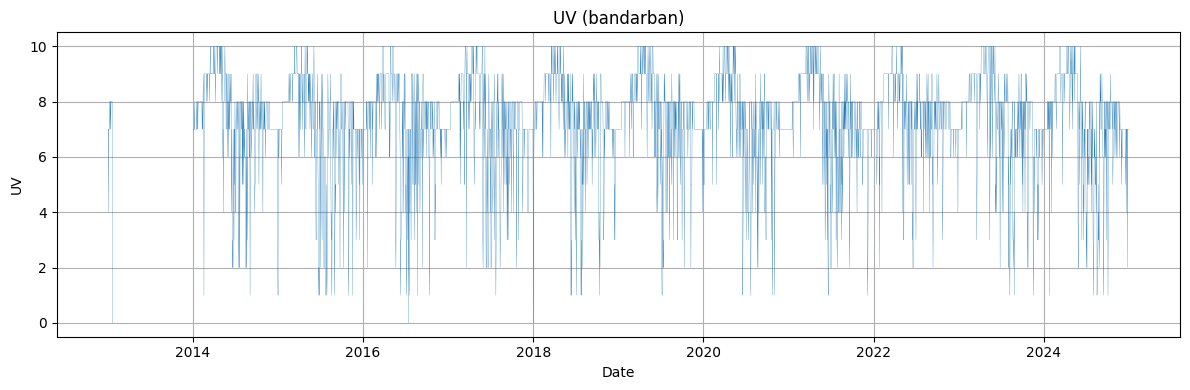

In [267]:
import matplotlib.pyplot as plt

if 'date' not in df_bandarban.columns:
    df_bandarban['date'] = pd.to_datetime(df_bandarban[['year', 'month', 'day']])

# df_bandarban = df_bandarban[
#     (df_bandarban['date'] >= '2014-01-01') & (df_bandarban['date'] <= '2024-12-31')
# ]

min_date = df_bandarban['date'].min()
max_date = df_bandarban['date'].max()

plt.figure(figsize=(12, 6))
plt.plot(df_bandarban['date'], df_bandarban['max_temperature(degree C)'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Max Temperature (bandarban)')
plt.grid(True)
plt.tight_layout()
plt.show()

# plot daily humidity time series
plt.figure(figsize=(12, 4))
plt.plot(df_bandarban['date'], df_bandarban['atmospheric_pressure'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('atm)')
plt.title('Daily atmospheric_pressure (bandarban)')
plt.grid(True)
plt.tight_layout()
plt.show()

# dew point
plt.figure(figsize=(12, 4))
plt.plot(df_bandarban['date'], df_bandarban['solar_radiation'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('solar_radiation')
plt.title('solar_radiation (bandarban)')
plt.grid(True)
plt.tight_layout()
plt.show()

#  UV
plt.figure(figsize=(12, 4))
plt.plot(df_bandarban['date'], df_bandarban['UV'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('UV')
plt.title('UV (bandarban)')
plt.grid(True)
plt.tight_layout()
plt.show()



In [268]:
df_bandarban.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16437 entries, 0 to 16436
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   day                            16437 non-null  int64         
 1   month                          16437 non-null  int64         
 2   year                           16437 non-null  int64         
 3   temperature(degree C)          14764 non-null  float64       
 4   feels_like(degree C)           14764 non-null  float64       
 5   max_temperature(degree C)      15149 non-null  float64       
 6   minimum_temperature(degree C)  15149 non-null  float64       
 7   humidity                       14764 non-null  float64       
 8   precipitation                  5479 non-null   float64       
 9   windspeed                      16052 non-null  float64       
 10  atmospheric_pressure           14687 non-null  float64       
 11  UV             

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'solar_radiation','humidity','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}', f'solar_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'hum_roll_7', 'solar_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [ ]:
FEATURES = [
    'solar_radiation',
    'humidity',
    'max_temperature(degree C)', # ~1.41   r2 -> 90.47/89.06
    'solar_lag_1' # ~ 1.18 r2 -> 90.96/89.78
    # 'solar_roll_7', # ~ 1.33 r2 90.81/89.48
    # 'hum_lag_1', # ~ 1.55 r2
    # 'ppt_lag_1' # ~ 1.84 r2
    # 'day_of_year_sin_1', # r2 -> 91.14/89.50  ~ 1.64
    ]

# FEATURES = ['day', 'month', 'year','solar_radiation', 'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)

X = df[FEATURES]
y = df['UV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

NameError: name 'fourier_cols' is not defined

# RF with rolling lagging

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

'''
Random Forest Feature Importances (from last fold):
                      Feature  Importance
3             solar_radiation    0.340048
4                    humidity    0.126609
14                solar_lag_1    0.096553
23               solar_roll_7    0.069709
6           day_of_year_sin_1    0.046662
13                  hum_lag_1    0.042154
5   max_temperature(degree C)    0.038953
17                solar_lag_2    0.035962
1                       month    0.026817
22                 hum_roll_7    0.023783
20                solar_lag_3    0.021470
7           day_of_year_cos_1    0.016534
9           day_of_year_cos_2    0.013434
16                  hum_lag_2    0.013410
21                temp_roll_7    0.011104
12                 temp_lag_1    0.010980
19                  hum_lag_3    0.010869
11          day_of_year_cos_3    0.010002
8           day_of_year_sin_2    0.008935
10          day_of_year_sin_3    0.008132
18                 temp_lag_3    0.007781
15                 temp_lag_2    0.007447
0                         day    0.007312
2                        year    0.005341
'''


rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for UV:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# Feature importance - Using the model from the LAST fold
importance = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nRandom Forest Feature Importances (from last fold):")
print(feature_importance_df_rf)




Random Forest Results for UV:
MSE: 0.2944
RMSE: 0.5426
R² Score: 0.9096
Average RMSE from CV: 0.5595
Average R² from CV: 0.8978
Avarage MSE: 0.3134357565820247
Individual Fold RMSEs: [np.float64(0.5696341574245429), np.float64(0.5708607959548089), np.float64(0.5427198617673873), np.float64(0.5308386822580157), np.float64(0.5835058751280556)]

 R2 ~ 1.1862

Random Forest Feature Importances (from last fold):
                     Feature  Importance
0            solar_radiation    0.656200
1                   humidity    0.186313
3                solar_lag_1    0.130781
2  max_temperature(degree C)    0.026706


# RF-LSTM hybrid

In [272]:
# FEATURES = ['day', 'month', 'year','solar_radiation', 'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)

FEATURES = [
    'solar_radiation',
    'humidity',
    'max_temperature(degree C)', # ~1.41   r2 -> 90.47/89.06
    'solar_lag_1' # ~ 1.18 r2 -> 90.96/89.78
    # 'solar_roll_7', # ~ 1.33 r2 90.81/89.48
    # 'hum_lag_1', # ~ 1.55 r2
    # 'ppt_lag_1' # ~ 1.84 r2
    # 'day_of_year_sin_1', # r2 -> 91.14/89.50  ~ 1.64
    ]

X = df[FEATURES]
y = df['UV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= False)


In [273]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")

# window 3 == r2 -> 86.57
# window 7 == r2 -> 86.81
# window 5 == r2 -> 87.33

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Windowed UV R2: 0.9095
Windowed UV MSE: 0.2964
Windowed UV RMSE: 0.5444


In [274]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# --- STEP 1: Selective Features for LSTM ---
# We only give the LSTM the most important "weather" features to reduce noise
lstm_feature_cols = ['solar_radiation' , 'humidity','solar_lag_1']
X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections[:, 0]

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final UV R2: {rf_lstm_r2:.4f}")
print(f"Final UV MSE: {rf_lstm_mse:.4f}")
print(f"Final UV RMSE: {rf_lstm_mse:.4f}")
# final r2 90.90/89.87 

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
--- HYBRID MODEL PERFORMANCE ---
Final UV R2: 0.9088
Final UV MSE: 0.2963
Final UV RMSE: 0.2963


In [275]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace

UV = 'UV'
X_full = df[FEATURES]
y_full = df[UV]

fold = 1
lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf_model.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf_model.predict(X_train_cv)
    
    # --- STEP 2: Preprocessing for LSTM ---
    lstm_feature_cols = ['solar_radiation' , 'humidity','solar_lag_1']

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 5
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf_model.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")

# R2 -> 90.86/89.86 ~~ 0.88 [better than single RF]

--- Processing Fold 1 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Fold 1 R2: 0.9088
Fold 1 MSE: 0.3266
Fold 1 RMSE: 0.5715
--- Processing Fold 2 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Fold 2 R2: 0.8888
Fold 2 MSE: 0.3115
Fold 2 RMSE: 0.5581
--- Processing Fold 3 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Fold 3 R2: 0.8990
Fold 3 MSE: 0.2932
Fold 3 RMSE: 0.5415
--- Processing Fold 4 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Fold 4 R2: 0.8883
Fold 4 MSE: 0.2824
Fold 4 RMSE: 0.5315
--- Processing Fold 5 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Fold 5 R2: 0.9083
Fold 5 MSE: 0.3432
Fold 5 RMSE: 0.5858

--- FINAL CROSS-VALIDATION RESULTS ---
Mean R2: 0.8987 (+/- 0.0089)
Mean mse: 0.3114 (+/- 0.0219)
Mean rmse: 0.5577 (+/- 0.0196)


# XGBoost

In [276]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'solar_radiation','humidity','precipitation','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}', f'solar_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'hum_roll_7', 'solar_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [277]:

# FEATURES = ['solar_lag_1','solar_roll_7','solar_lag_3','day_of_year_cos_2']
# FEATURES = ['day', 'month', 'year','solar_radiation', 'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)

FEATURES = [
    'solar_radiation', # r2 90.24/88.73  ~ 1.51 better
    # 'day_of_year_cos_2', # r2 88.49/86.58  ~ 1.91
    # 'day_of_year_cos_1' # r2 89.09/86.68  ~ 2.41
    ]

X = df[FEATURES]
y = df['UV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [278]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

'''
XGBoost Feature Importances:
                      Feature  Importance
3             solar_radiation    0.819838
9           day_of_year_cos_2    0.024133
7           day_of_year_cos_1    0.014930
6           day_of_year_sin_1    0.010010
23               solar_roll_7    0.008748
8           day_of_year_sin_2    0.008573
22                 hum_roll_7    0.008510
14                solar_lag_1    0.008248
20                solar_lag_3    0.008166
17                solar_lag_2    0.007750
19                  hum_lag_3    0.006980
5   max_temperature(degree C)    0.006977
18                 temp_lag_3    0.006970
4                    humidity    0.006926
21                temp_roll_7    0.006639
16                  hum_lag_2    0.006574
15                 temp_lag_2    0.006527
13                  hum_lag_1    0.006222
12                 temp_lag_1    0.006044
10          day_of_year_sin_3    0.005698
11          day_of_year_cos_3    0.005692
2                        year    0.003397
0                         day    0.003377
1                       month    0.003070
'''

targets = y
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_xgb = {}


xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)


print(f"\nXGBoost Results for UV:")
print(f'Mean Squared Error: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')


# K-Fold cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_xgb = []
r2_list_xgb = [] # Added to track R2 across all folds
mse_list_xgb = []

for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]

        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

        mse_list_xgb.append(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        r2_list_xgb.append(r2_kf_xgb)


        average_rmse_xgb = np.mean(rmse_list_xgb)
        average_r2_xgb = np.mean(r2_list_xgb)
        average_mse_xgb = np.mean(mse_kf_xgb)
        

print ("\n")
print(f"Average RMSE from CV: {average_rmse_xgb:.4f}")
print(f"Average R² from CV: {average_r2_xgb:.4f}")
print(f"Avarage MSE: {average_mse_xgb}")
print(f"Individual Fold RMSEs: {rmse_list_xgb}")

# Feature importance for XGBoost
importance = xgb_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

diff = (r2_xgb - average_r2_xgb)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)



XGBoost Results for UV:
Mean Squared Error: 0.3181
RMSE: 0.5640
R² Score: 0.9024


Average RMSE from CV: 0.5875
Average R² from CV: 0.8873
Avarage MSE: 0.3499085320286909
Individual Fold RMSEs: [np.float64(0.6233042231156081), np.float64(0.5963017225651084), np.float64(0.568276519355187), np.float64(0.5580152404258877), np.float64(0.5915306687135425)]

 R2 ~ 1.5081

XGBoost Feature Importances:
           Feature  Importance
0  solar_radiation         1.0


# Light GBM

In [279]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'solar_radiation','humidity','precipitation','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}', f'solar_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'hum_roll_7', 'solar_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [280]:
# FEATURES = ['day', 'month', 'year','solar_radiation', 'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)

FEATURES = [
    'solar_radiation', 
    'humidity', 
    'solar_lag_1', 
    'solar_roll_7', # r2 90.85/89.61       ~ 1.24
    'solar_lag_2', # r2 90.94/89.78        ~ 1.16
    'day_of_year_cos_1', # r2 90.79/89.62  ~ 1.17
    'hum_lag_3', # r2 90.77/89.77          ~ 1
    # 'hum_roll_7', # ~ 1.18
    ]

X = df[FEATURES]
y = df['UV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [281]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


''''
LightGBM Feature Importances:
                      Feature  Importance
3             solar_radiation        1111
4                    humidity         499
14                solar_lag_1         300
23               solar_roll_7         219
17                solar_lag_2         205
7           day_of_year_cos_1         199
19                  hum_lag_3         196
22                 hum_roll_7         173
13                  hum_lag_1         162
5   max_temperature(degree C)         156
0                         day         145
6           day_of_year_sin_1         142
9           day_of_year_cos_2         140
16                  hum_lag_2         122
20                solar_lag_3         114
8           day_of_year_sin_2         111
12                 temp_lag_1         106
11          day_of_year_cos_3         104
18                 temp_lag_3          99
21                temp_roll_7          94
10          day_of_year_sin_3          87
2                        year          83
15                 temp_lag_2          60
1                       month          16
'''

targets = y
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}


lgb_model = lgb.LGBMRegressor(
        # n_estimators=800,
        # learning_rate=0.01,
        # max_depth=8,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # random_state=42,
        # verbosity=-1

        n_estimators=300,        # Reduced to prevent memorization as UV r 4k dataset
        learning_rate=0.03,      # Slightly faster learning for fewer trees
        max_depth=6,             # Shallow trees are better for 4k rows
        num_leaves=20,           # Controls complexity
        min_child_samples=40,    # Ensures each "leaf" represents enough data
        subsample=0.7,           # More aggressive sampling for better generalization
        colsample_bytree=0.7,    # Uses 70% of features per tree
        random_state=42,
        verbosity=-1
                              # Clean console
    )

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print(f"\nLightGBM Results for UV:")
print(f'Mean Squared Error: {mse_lgb:.4f}')
print(f'RMSE: {rmse_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')


    # --- 6) 5-fold CV R^2 ---
tscv = TimeSeriesSplit(n_splits=5)
    
rmse_list_lgb = []
r2_list_lgb = []
mse_list_lgb = []


for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        lgb_model_kf = lgb.LGBMRegressor(
            # n_estimators=800,
            # learning_rate=0.01,
            # max_depth=8,
            # subsample=0.8,
            # colsample_bytree=0.8,
            # random_state=42,
            # verbosity=-1

            n_estimators=300,        # Reduced to prevent memorization
            learning_rate=0.03,      # Slightly faster learning for fewer trees
            max_depth=6,             # Shallow trees are better for 4k rows
            num_leaves=20,           # Controls complexity
            min_child_samples=40,    # Ensures each "leaf" represents enough data
            subsample=0.7,           # More aggressive sampling for better generalization
            colsample_bytree=0.7,    # Uses 70% of features per tree
            random_state=42,
            verbosity=-1             # Clean console
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)
        
        mse_list_lgb.append(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        r2_list_lgb.append(r2_kf_lgb)

        average_rmse_lgb = np.mean(rmse_list_lgb)
        average_r2_lgb = np.mean(r2_list_lgb)
        average_mse_lgb = np.mean(mse_kf_lgb)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_lgb:.4f}")
print(f"Average R² from CV: {average_r2_lgb:.4f}")
print(f"Avarage MSE: {average_mse_lgb}")
print(f"Individual Fold RMSEs: {rmse_list_lgb}")

# Feature importance for LightGBM
importance = lgb_model.feature_importances_
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

diff = (r2_lgb - average_r2_lgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLightGBM Feature Importances:")
print(feature_importance_df_lgb)

# n = 800, maxdept 10 -> 90.77/89.30 ##
# maxdept 8 -> 90.81/89.36           ##  
                                     ## while full features were used  
# n = 300, maxdept 6 -> 90.67/89.47  ##


LightGBM Results for UV:
Mean Squared Error: 0.3007
RMSE: 0.5483
R² Score: 0.9077


Average RMSE from CV: 0.5610
Average R² from CV: 0.8977
Avarage MSE: 0.34489668133294255
Individual Fold RMSEs: [np.float64(0.5928409332075634), np.float64(0.5583369598823955), np.float64(0.5454875639599384), np.float64(0.5210618152895712), np.float64(0.5872790489477234)]

 R2 ~ 1.0053

LightGBM Feature Importances:
             Feature  Importance
0    solar_radiation        1320
1           humidity         689
5  day_of_year_cos_1         668
2        solar_lag_1         539
6          hum_lag_3         498
3       solar_roll_7         455
4        solar_lag_2         436


# CatBoost

In [282]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'solar_radiation','humidity','precipitation','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}', f'solar_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'hum_roll_7', 'solar_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [283]:

# FEATURES = ['day', 'month', 'year','solar_radiation', 'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# overall -> 91.14/90.02


FEATURES = [
    'solar_radiation', 
    'solar_lag_1', 
    'solar_roll_7', 
    'humidity',
    'day_of_year_cos_2',
    'day_of_year_sin_1',
    'max_temperature(degree C)',
    'day_of_year_cos_1', 
    'solar_lag_3', # 91.06/90.08 ~ 0.98
    'hum_lag_3', # 91.01/90.16 ~ 0.85
    ]

X = df[FEATURES]
y = df['UV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [284]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split


''''
CatBoost Feature Importances:
                      Feature  Importance
3             solar_radiation   78.382623
14                solar_lag_1    2.431335
23               solar_roll_7    2.285712
4                    humidity    1.325851
9           day_of_year_cos_2    1.164114
6           day_of_year_sin_1    1.134604
5   max_temperature(degree C)    1.092322
7           day_of_year_cos_1    0.996233
20                solar_lag_3    0.966329
17                solar_lag_2    0.864024
19                  hum_lag_3    0.862907
22                 hum_roll_7    0.819920
11          day_of_year_cos_3    0.818648
13                  hum_lag_1    0.816178
8           day_of_year_sin_2    0.749622
0                         day    0.739146
21                temp_roll_7    0.709767
10          day_of_year_sin_3    0.671552
16                  hum_lag_2    0.643892
12                 temp_lag_1    0.616254
18                 temp_lag_3    0.607127
2                        year    0.555630
15                 temp_lag_2    0.386791
1                       month    0.359417
'''

targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for UV :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)

        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# Feature importance for LightGBM
importance = cat_model.feature_importances_
feature_names = X.columns
feature_importance_df_cat = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    



LightGBM Results for UV :
Mean Squared Error: 0.2928
RMSE: 0.5411
R² Score: 0.9101


Average RMSE from CV: 0.5502
Average R² from CV: 0.9016
Avarage MSE: 0.30349912405842333
Individual Fold RMSEs: [np.float64(0.5793631379079237), np.float64(0.5528248223651883), np.float64(0.5351369374655289), np.float64(0.5057891470571911), np.float64(0.5779485162033662)]

 R2 ~ 0.8561

CatBoost Feature Importances:
                     Feature  Importance
0            solar_radiation   78.352652
1                solar_lag_1    3.960087
2               solar_roll_7    2.808795
3                   humidity    2.558291
8                solar_lag_3    2.152689
5          day_of_year_sin_1    2.128006
9                  hum_lag_3    2.098468
6  max_temperature(degree C)    2.032795
7          day_of_year_cos_1    2.024961
4          day_of_year_cos_2    1.883256


# GRU

In [285]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'solar_radiation','humidity','precipitation','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}', f'solar_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'hum_roll_7', 'solar_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [286]:

# FEATURES = ['day', 'month', 'year','solar_radiation', 'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# r2 90/89.11 ~ 0.89


FEATURES = [
    'solar_radiation', 
    'temp_roll_7', 
    'hum_lag_3', # 91.08/90.10 ~0.98
    'temp_lag_1', # 90.99/90.14 ~ 0.85 [ better baba]
    # 'solar_roll_7'# 91.12/90.12 ~ 1
    ]

''''

GRU Permutation Feature Importances:
                      Feature  Importance
3             solar_radiation    5.537160
21                temp_roll_7    0.029903
19                  hum_lag_3    0.028459
12                 temp_lag_1    0.019108
23               solar_roll_7    0.017540
1                       month    0.016068
7           day_of_year_cos_1    0.014838
6           day_of_year_sin_1    0.013519
18                 temp_lag_3    0.010520
5   max_temperature(degree C)    0.010262
9           day_of_year_cos_2    0.009613
15                 temp_lag_2    0.008773
13                  hum_lag_1    0.004471
11          day_of_year_cos_3    0.002343
0                         day    0.000447
2                        year    0.000000
4                    humidity    0.000000
14                solar_lag_1    0.000000
8           day_of_year_sin_2    0.000000
10          day_of_year_sin_3    0.000000
16                  hum_lag_2    0.000000
17                solar_lag_2    0.000000
20                solar_lag_3    0.000000
22                 hum_roll_7    0.000000

'''

X = df[FEATURES]
y = df['UV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [287]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam

# 1. Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for GRU: (samples, time_steps, features)
# Here we use time_steps=1. If you want sequences, you'd need a sliding window function.
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data (matching your non-shuffle 80/20 split)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


In [288]:
def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='relu', input_shape=input_shape, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train initial model
gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
gru_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predict and Inverse Scale
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

mse_gru = mean_squared_error(y_test_unscaled, y_pred)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_unscaled, y_pred)

print(f"\nGRU Results for UV :")
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'RMSE: {rmse_gru:.4f}')
print(f'R² Score: {r2_gru:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild/Reset model for each fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = gru_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_gru = np.mean(r2_list_gru)
average_mse_gru = np.mean(mse_list_gru)
average_rmse_gru = np.mean(rmse_list_gru)

print("\n")
print(f"Average RMSE from CV: {average_rmse_gru:.4f}")
print(f"Average R² from CV: {average_r2_gru:.4f}")
print(f"Average MSE: {average_mse_gru:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_gru}")

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

GRU Results for UV :
Mean Squared Error: 0.2898
RMSE: 0.5383
R² Score: 0.9110


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Average RMSE from CV: 0.5518
Average R² from CV: 0.9003
Average MSE: 0.3047
Individual Fold RMSEs: [np.float64(0.5425996827286605), np.float64(0.559405011869296), np.float64(0.5507041956305879), np.float64(0.5286004168484547), np.float64(0.5774599827201151)]


In [289]:
# Permutation Importance Implementation

import pandas as pd
import numpy as np

def calculate_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Calculates importance by measuring how much the MSE increases 
    when a single feature is randomly shuffled.
    """
    # Baseline prediction
    baseline_preds = model.predict(X_val, verbose=0)
    baseline_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                     scaler_y.inverse_transform(baseline_preds))
    
    importances = []
    
    for i in range(X_val.shape[2]):  # Iterate through each feature
        save = X_val[:, :, i].copy()
        
        # Shuffle the current feature across all samples
        np.random.shuffle(X_val[:, :, i])
        
        # Predict with shuffled feature
        shuffled_preds = model.predict(X_val, verbose=0)
        shuffled_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                         scaler_y.inverse_transform(shuffled_preds))
        
        # Importance is the increase in error
        importances.append(max(0, shuffled_mse - baseline_mse))
        
        # Restore the original feature values
        X_val[:, :, i] = save

    # Create DataFrame
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    return importance_df.sort_values(by='Importance', ascending=False)

# --- Execute ---
# Note: Use your X_test and y_test from the previous step
feature_importance_gru = calculate_permutation_importance(
    gru_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)

diff = (r2_gru - np.mean(r2_list_gru))*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nGRU Permutation Feature Importances:")
print(feature_importance_gru)


 R2 ~ 1.0700

GRU Permutation Feature Importances:
           Feature  Importance
0  solar_radiation    5.596561
3       temp_lag_1    0.038288
1      temp_roll_7    0.015285
2        hum_lag_3    0.007142


# LSTM

In [290]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'solar_radiation','humidity','precipitation','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}', f'solar_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'hum_roll_7', 'solar_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [291]:

# FEATURES = ['day', 'month', 'year','solar_radiation', 'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# r2 89.18/89.11 ~ 0.89


FEATURES = [
    'solar_radiation', 
    'hum_lag_3', # 91.17/90.09 ~ 1.08
    'temp_roll_7', # 91.21/90.22 ~0.99
    'month', # 91.18/90.28 ~ 0.9 
    'hum_lag_1', # 90.87/90.24 ~ 0.62 [best]
    # 'solar_roll_7', # 91.21/89.99 ~1.22
    # 'hum_lag_2', # 91.22/90.02 ~ 1.25
    ]

''''
LSTM Permutation Feature Importances:
                      Feature  Importance
3             solar_radiation    5.533576
19                  hum_lag_3    0.040568
21                temp_roll_7    0.027770
1                       month    0.023069
13                  hum_lag_1    0.020558
23               solar_roll_7    0.012792
5   max_temperature(degree C)    0.010470
22                 hum_roll_7    0.009184
14                solar_lag_1    0.007246
16                  hum_lag_2    0.006634
12                 temp_lag_1    0.006100
7           day_of_year_cos_1    0.005729
6           day_of_year_sin_1    0.005563
10          day_of_year_sin_3    0.004782
9           day_of_year_cos_2    0.004685
18                 temp_lag_3    0.002820
2                        year    0.000701
0                         day    0.000000
4                    humidity    0.000000
8           day_of_year_sin_2    0.000000
15                 temp_lag_2    0.000000
11          day_of_year_cos_3    0.000000
17                solar_lag_2    0.000000
20                solar_lag_3    0.000000

'''

X = df[FEATURES]
y = df['UV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# 1. Scale Features and Target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for LSTM: [samples, time_steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split matching your CatBoost logic (shuffle=False)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\nLSTM Results for UV :")
print(f'Mean Squared Error: {mse_lstm:.4f}')    
print(f'RMSE: {rmse_lstm:.4f}')
print(f'R² Score: {r2_lstm:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_lstm = []
r2_list_lstm = []
mse_list_lstm = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Re-instantiate model for each fold
    lstm_kf = build_lstm((X_train_kf.shape[1], X_train_kf.shape[2]))
    lstm_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = lstm_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_lstm.append(np.sqrt(mse_kf))
    mse_list_lstm.append(mse_kf)
    r2_list_lstm.append(r2_score(y_test_kf_unscaled, y_pred_kf))


average_r2_lstm = np.mean(r2_list_lstm)
average_mse_lstm = np.mean(mse_list_lstm)
average_rmse_lstm = np.mean(rmse_list_lstm)
 
print("\n")
print(f"Average RMSE from LSTM CV: {average_rmse_lstm:.4f}")
print(f"Average R² from LSTM CV: { average_r2_lstm:.4f}")
print(f"Average MSE: {average_mse_lstm:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_lstm}")

def calculate_lstm_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Computes permutation importance for a trained LSTM model.
    """
    # 1. Get baseline score (Inverse scale to get real-world MSE)
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    
    # Iterate through each feature index
    for i in range(X_val.shape[2]):
        # Create a copy to avoid permanent shuffling
        X_permuted = X_val.copy()
        
        # 2. Shuffle the specific feature across all samples
        # Shuffling happens across the 'samples' dimension for the i-th feature
        np.random.shuffle(X_permuted[:, :, i])
        
        # 3. Predict with the permuted feature
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        # 4. Importance = Increase in Error (shuffled error - baseline error)
        importance = max(0, permuted_mse - baseline_mse)
        importance_results.append(importance)

    # Organize into a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': importance_results
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

# --- Execution ---
# Using the X_test and y_test from your LSTM training
lstm_importance_df = calculate_lstm_permutation_importance(
    lstm_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)

diff = (r2_lstm - np.mean(r2_list_lstm))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLSTM Permutation Feature Importances:")
print(lstm_importance_df)

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

LSTM Results for UV :
Mean Squared Error: 0.3008
RMSE: 0.5484
R² Score: 0.9077


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Average RMSE from LSTM CV: 0.5461
Average R² from LSTM CV: 0.9025
Average MSE: 0.2985
Individual Fold RMSEs: [np.float64(0.5441619640735221), np.float64(0.5546614500696594), np.float64(0.5399863502619929), np.float64(0.5197278914685199), np.float64(0.5718145549214632)]

 R2 ~ 0.5155

LSTM Permutation Feature Importances:
           Feature  Importance
0  solar_radiation    5.485627
2      temp_roll_7    0.024694
3            month    0.019021
4        hum_lag_1    0.011046
1        hum_lag_3    0.010305


# ANN

In [293]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'solar_radiation','humidity','precipitation','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}', f'solar_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'hum_roll_7', 'solar_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [294]:

# FEATURES = ['day', 'month', 'year','solar_radiation', 'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# r2 86.73/87.90  ~-1.17


FEATURES = [
    'solar_radiation', 
    'solar_lag_1', 
    'hum_lag_3', # 90.76/90.09 ~0.66 [ best ]
    # 'hum_lag_1', # 91.19/89.58 ~1.61
    # 'hum_lag_2', # 90.51/89.47 ~1.04

    ]

''''
ANN Permutation Feature Importances:
                      Feature  Importance
3             solar_radiation    4.466280
14                solar_lag_1    0.120132
19                  hum_lag_3    0.075960
13                  hum_lag_1    0.054734
16                  hum_lag_2    0.045045
5   max_temperature(degree C)    0.037598
23               solar_roll_7    0.032748
1                       month    0.032363
11          day_of_year_cos_3    0.030868
21                temp_roll_7    0.029252
18                 temp_lag_3    0.025757
0                         day    0.024950
12                 temp_lag_1    0.015836
10          day_of_year_sin_3    0.009428
2                        year    0.009011
9           day_of_year_cos_2    0.004499
15                 temp_lag_2    0.001691
22                 hum_roll_7    0.001610
20                solar_lag_3    0.000428
4                    humidity    0.000000
7           day_of_year_cos_1    0.000000
6           day_of_year_sin_1    0.000000
8           day_of_year_sin_2    0.000000
17                solar_lag_2    0.000000

'''

X = df[FEATURES]
y = df['UV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [295]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for UV :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

ANN Results for UV :
Mean Squared Error: 0.3189
RMSE: 0.5647
R² Score: 0.9021


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Average RMSE from ANN CV: 0.5619
Average R² from ANN CV: 0.8969
Average MSE: 0.3164
Individual Fold RMSEs: [np.float64(0.5500820721334646), np.float64(0.5634237282082692), np.float64(0.5536885695206555), np.float64(0.5350064350043626), np.float64(0.6075054308610417)]

 R2 ~ 0.5207

ANN Permutation Feature Importances:
           Feature  Importance
0  solar_radiation    5.265234
1      solar_lag_1    0.048940
2        hum_lag_3    0.011428


# CNN-LSTM hybrid

In [296]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'solar_radiation','humidity','precipitation','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}', f'solar_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'hum_roll_7', 'solar_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [297]:

# FEATURES = ['day', 'month', 'year','solar_radiation', 'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# r2 44/42


FEATURES = [
    'solar_radiation', 
    'hum_lag_3', 
    'temp_roll_7', 
    'month', 
    'hum_lag_1', # 45/43
    # 'solar_roll_7', 
    # 'hum_lag_2', # 30/43
    ]

''''
# LSTM er feature importance theke tweeg kora

'''

X = df[FEATURES]
y = df['UV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [298]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

def model_builder(hp):
    model = Sequential()
    
    # Tune CNN Filters
    hp_filters = hp.Int('filters', min_value=32, max_value=64, step=32)
    model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu', input_shape=(100,1)))
    model.add(MaxPooling1D(pool_size=2))
    
    # Tune Dropout
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout))

    # Tune LSTM Units
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=64, step=16)
    model.add(LSTM(units=hp_lstm_units, activation='tanh'))
    model.add(Dropout(hp_dropout))

    # Final Dense Layers
    model.add(Dense(hp.Int('dense_units', 16, 64, 16), activation='relu'))
    model.add(Dense(1))

    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Example: Using the last 30 days to predict tomorrow
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# X_3D shape will be (Total_Days, 30, 1)
X_3D, y_target = create_sequences(df['UV'].values)
X_3D = X_3D.reshape((X_3D.shape[0], X_3D.shape[1], 1))

In [299]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['UV'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")

c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Base Results: R2: 0.4729, MSE: 1.7217, RMSE: 1.3121


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5-Fold CV Average: R2: 0.4422, MSE: 1.8002, RMSE: 1.3409


In [314]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [True, True])

print (df_performance)

             Model       R^2      CVR2   R2 DIFF       MSE    MSE CV  \
6             LSTM  0.907669  0.902514  0.005155  0.300794  0.298487   
7              ANN  0.902101  0.896894  0.005207  0.318933  0.316380   
4         CatBoost  0.910123  0.901562  0.008561  0.292798  0.303499   
3         LightGBM  0.907704  0.897651  0.010053  0.300678  0.344897   
1   RF-LSTM hybrid  0.908755  0.898650  0.010104  0.296311  0.311386   
5              GRU  0.911043  0.900342  0.010700  0.289803  0.304700   
0    Random Forest  0.909640  0.897778  0.011862  0.294371  0.313436   
2          XGBoost  0.902361  0.887280  0.015081  0.318085  0.349909   
8  CNN-LSTM hybrid  0.472865  0.442205  0.030660  1.721673  1.800162   

       RMSE   RMSE CV  
6  0.548447  0.546070  
7  0.564741  0.561941  
4  0.541109  0.550213  
3  0.548341  0.561001  
1  0.544344  0.557673  
5  0.538333  0.551754  
0  0.542559  0.559512  
2  0.563990  0.587486  
8  1.312126  1.340852  


In [316]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE'] +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")

🥇 The Best Logical Model is: CatBoost
--- Reason: Balanced score across R^2 (0.9101) and Stability (DIFF: 0.0086)


# Predicting the next 365 days using the best model

- jeita best oita abr notun kore run deyaici. caz pura ta abar train koraite huge time laiga jay. (na bujhle ask me)

In [1]:
import pandas as pd
import numpy as np

df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import TimeSeriesSplit

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'solar_radiation','humidity','precipitation','max_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['max_temperature(degree C)'].shift(lag)
    df[f'hum_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}', f'solar_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['max_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df['humidity'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'hum_roll_7', 'solar_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



# FEATURES = ['day', 'month', 'year','solar_radiation', 'humidity', 'max_temperature(degree C)'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# overall -> 91.14/90.02


FEATURES = [
    'solar_radiation', 
    'solar_lag_1', 
    'solar_roll_7', 
    'humidity',
    'day_of_year_cos_2',
    'day_of_year_sin_1',
    'max_temperature(degree C)',
    'day_of_year_cos_1', 
    'solar_lag_3', # 91.06/90.08 ~ 0.98
    'hum_lag_3', # 91.01/90.16 ~ 0.85
    ]

X = df[FEATURES]
y = df['UV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)



''''
CatBoost Feature Importances:
                      Feature  Importance
3             solar_radiation   78.382623
14                solar_lag_1    2.431335
23               solar_roll_7    2.285712
4                    humidity    1.325851
9           day_of_year_cos_2    1.164114
6           day_of_year_sin_1    1.134604
5   max_temperature(degree C)    1.092322
7           day_of_year_cos_1    0.996233
20                solar_lag_3    0.966329
17                solar_lag_2    0.864024
19                  hum_lag_3    0.862907
22                 hum_roll_7    0.819920
11          day_of_year_cos_3    0.818648
13                  hum_lag_1    0.816178
8           day_of_year_sin_2    0.749622
0                         day    0.739146
21                temp_roll_7    0.709767
10          day_of_year_sin_3    0.671552
16                  hum_lag_2    0.643892
12                 temp_lag_1    0.616254
18                 temp_lag_3    0.607127
2                        year    0.555630
15                 temp_lag_2    0.386791
1                       month    0.359417
'''

targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for UV :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)

        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# Feature importance for LightGBM
importance = cat_model.feature_importances_
feature_names = X.columns
feature_importance_df_cat = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    



LightGBM Results for UV :
Mean Squared Error: 0.2928
RMSE: 0.5411
R² Score: 0.9101


Average RMSE from CV: 0.5502
Average R² from CV: 0.9016
Avarage MSE: 0.30349912405842333
Individual Fold RMSEs: [np.float64(0.5793631379079237), np.float64(0.5528248223651883), np.float64(0.5351369374655289), np.float64(0.5057891470571911), np.float64(0.5779485162033662)]

 R2 ~ 0.8561

CatBoost Feature Importances:
                     Feature  Importance
0            solar_radiation   78.352652
1                solar_lag_1    3.960087
2               solar_roll_7    2.808795
3                   humidity    2.558291
8                solar_lag_3    2.152689
5          day_of_year_sin_1    2.128006
9                  hum_lag_3    2.098468
6  max_temperature(degree C)    2.032795
7          day_of_year_cos_1    2.024961
4          day_of_year_cos_2    1.883256


C:\Users\Khalid\AppData\Local\Temp\ipykernel_2468\2773410839.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_future['solar_lag_1'] = df_future['solar_radiation'].shift(1).fillna(method='bfill')
C:\Users\Khalid\AppData\Local\Temp\ipykernel_2468\2773410839.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_future['solar_lag_3'] = df_future['solar_radiation'].shift(3).fillna(method='bfill')
C:\Users\Khalid\AppData\Local\Temp\ipykernel_2468\2773410839.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_future['hum_lag_3'] = df_future['humidity'].shift(3).fillna(method='bfill')
C:\Users\Khalid\AppData\Local\Temp\ipykernel_2468\2773410839.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will ra

--- 2-Year Forecast Generated ---
            Predicted_UV
Date                    
2025-01-01      6.043855
2025-01-02      6.800508
2025-01-03      6.905296
2025-01-04      6.951441
2025-01-05      7.017051
2025-01-06      7.041055
2025-01-07      7.021019
2025-01-08      7.025076
2025-01-09      7.023521
2025-01-10      7.000444


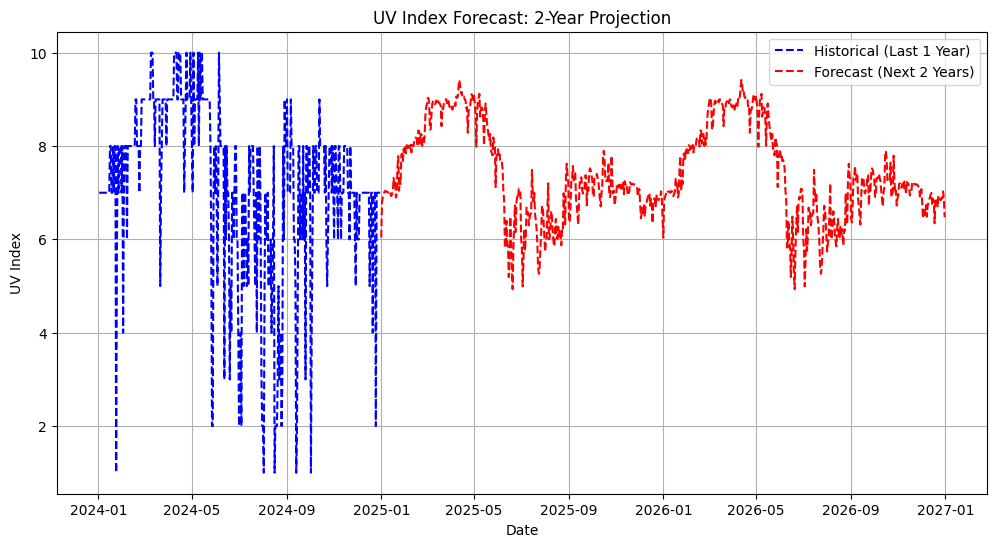

In [12]:
import pandas as pd
import numpy as np

# 1. Setup the Future Timeline
last_date = df['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365*2, freq="D")
df_future = pd.DataFrame({'date': future_dates})
df_future['day_of_year'] = df_future['date'].dt.dayofyear

# 2. Recreate Fourier Features (Purely Time-Based)
# Do this first so they are mathematically perfect for the future dates
df_future['day_of_year_sin_1'] = np.sin(2 * np.pi * 1 * df_future['day_of_year'] / 365.25)
df_future['day_of_year_cos_1'] = np.cos(2 * np.pi * 1 * df_future['day_of_year'] / 365.25)
df_future['day_of_year_cos_2'] = np.cos(2 * np.pi * 2 * df_future['day_of_year'] / 365.25)

# 3. Prepare Meteorological Seasonal Proxies
# We only want to average the ACTUAL weather variables from history
weather_vars = ['solar_radiation', 'humidity', 'max_temperature(degree C)']
seasonal_weather = df.groupby('day_of_year')[weather_vars].mean().reset_index()

# Merge only the raw weather proxies into the future
df_future = df_future.merge(seasonal_weather, on='day_of_year', how='left')

# 4. Recreate Lag and Rolling Features 
# We calculate these BASED on the seasonal weather we just merged
# This ensures 'solar_lag_1' is actually the solar radiation of the previous day
df_future['solar_lag_1'] = df_future['solar_radiation'].shift(1).fillna(method='bfill')
df_future['solar_lag_3'] = df_future['solar_radiation'].shift(3).fillna(method='bfill')
df_future['hum_lag_3'] = df_future['humidity'].shift(3).fillna(method='bfill')
df_future['solar_roll_7'] = df_future['solar_radiation'].rolling(window=7).mean().fillna(method='bfill')

# 5. Final Prediction
X_future = df_future[FEATURES] # FEATURES order is now preserved and clean
future_preds = cat_model.predict(X_future)

# 6. Store and Visualize Results
df_forecast_UV = pd.DataFrame({
    'Date': future_dates,
    'Predicted_UV': future_preds
}).set_index('Date')

print("--- 2-Year Forecast Generated ---")
print(df_forecast_UV.head(10))

# Plotting the result
plt.figure(figsize=(12, 6))
plt.plot(df.set_index('date')['UV'].iloc[-365:], label='Historical (Last 1 Year)', color='blue', linestyle = '--')
plt.plot(df_forecast_UV['Predicted_UV'], label='Forecast (Next 2 Years)', color='red', linestyle='--')
plt.title('UV Index Forecast: 2-Year Projection')
plt.xlabel('Date')
plt.ylabel('UV Index')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
df_2025 = pd.read_csv('../2025-dataset/bandarban_historical_weather_2025.csv')

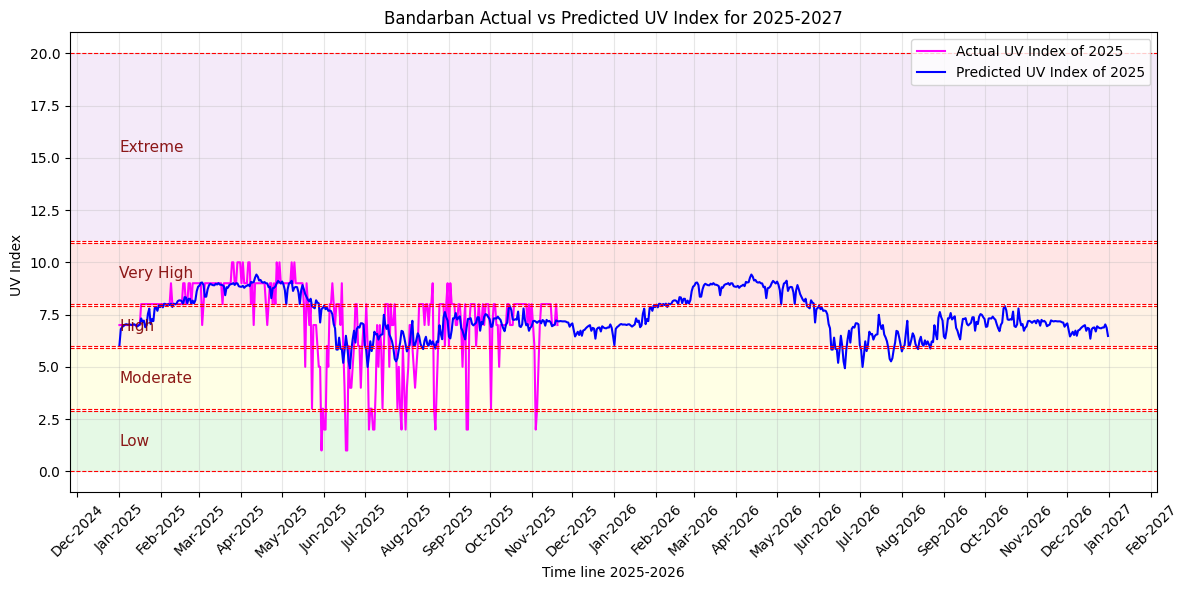

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,6))

def ensure_date(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df[["year", "month", "day"]])
    return df

# df_2025 = ensure_date(df_2025)
# df_forecast_UV = ensure_date(df_forecast_UV)

# df_2025 = df_2025.set_index("date")
# df_forecast_UV = df_forecast_UV.set_index("date")

plt.plot(df_2025.index, df_2025['UV'], 
         label='Actual UV Index of 2025', color='magenta')

plt.plot(df_forecast_UV.index, df_forecast_UV['Predicted_UV'], 
         label='Predicted UV Index of 2025', color='blue')

plt.xlabel("Time line 2025-2026")
plt.ylabel('UV Index ')
plt.title('Bandarban Actual vs Predicted UV Index for 2025-2027')

bands = [
    (0, 2.9, "Low", (0, 0.8, 0, 0.1)),           # Green
    (3, 5.9, "Moderate", (1, 1, 0, 0.1)),        # Yellow
    (6, 7.9, "High", (1, 0.5, 0, 0.1)),         # Orange
    (8, 10.9, "Very High", (1, 0, 0, 0.1)),      # Red
    (11, 20, "Extreme", (0.6, 0.2, 0.8, 0.1))    # Violet/Purple
]

ax = plt.gca()

for low, high, label, color in bands:
    ax.axhspan(low, high, facecolor=color, edgecolor=None)
    plt.axhline(y=low, color='red', linestyle='--', linewidth=0.8)
    plt.axhline(y=high, color='red', linestyle='--', linewidth=0.8)
    plt.text(
        x=df_2025.index.min(),
        y=(low + high) / 2,
        s=label,
        fontsize=11,
        color="maroon",
        va="center",
        ha="left",
        alpha=0.9
    )

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()